In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

## Sample
Megan Bedell made an awesome cross-match available, which was online by the time I woke up on West Coast!

Let's match this to the McQuillan+2014 rotation catalog using Pandas & a join

In [4]:
Gfile = '../data/kepler_dr2_1arcsec.fits' # from http://gaia-kepler.fun, thanks to M. Bedell
data = Table.read(Gfile, format='fits')
gaia = data.to_pandas()
gaia.shape

(195830, 101)

In [5]:
# gaia.columns.values

Text(0,0.5,'Bailer-Jones distance (pc)')

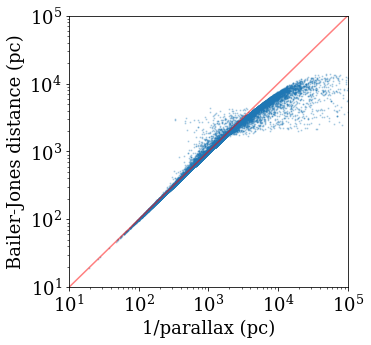

In [6]:
# Use the new distances that were published, should be better than just 1/plx
plt.figure(figsize=(5,5))

pok = np.where((gaia[u'r_modality_flag'] ==1) & (gaia[u'r_result_flag'] ==1))
plt.scatter(1000./gaia[u'parallax'].values[pok], gaia['r_est'].values[pok], s=1, alpha=0.25)

plt.plot([1,1e5], [1,1e5], c='r', alpha=0.5)
plt.xlim(10,1e5)
plt.ylim(10,1e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1/parallax (pc)')
plt.ylabel('Bailer-Jones distance (pc)')

In [7]:
rot_file = '../data/Table_Periodic.txt'
rot = pd.read_csv(rot_file)
rot.shape

(34030, 11)

In [8]:
df = pd.merge(rot, gaia, right_on='kepid', left_on='KID')
df.shape

(33538, 112)

In [9]:
# df.columns.values

## Quality Cuts
we need to trim the sample to get the best distances

In [10]:
ok = np.where(np.isfinite(df[u'parallax']) & # this is basically the same as the TGAS file...
              (df[u'parallax_error'] < 0.1) &
              (gaia[u'r_modality_flag'] == 1) & 
              (gaia[u'r_result_flag'] == 1) &
              np.isfinite(df[u'bp_rp']) & 
              (df[u'phot_bp_mean_flux_error']/df[u'phot_bp_mean_flux'] < 0.01) & 
              (df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01) & 
              (df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01))[0]

ok.shape

(30305,)

## The Gaia-Kepler Rotation CMD

We have 3 flavors of Isochrones to consider here:
- My normal go to, PARSEC
- the MIST set, which #gaiadr2 folks prefer & are based on MESA models
- YaPSI, which are all about rotation, but probably don't have colors we want

Text(0,0.5,'$M_R$ (mag)')

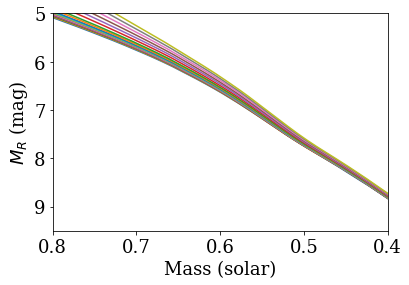

In [11]:
#   YaPSI - wrong bands, so work in relative sense...
Ynames = ('Age', 'M/Msun', 'logT', 'logL/Ls', 'logg', 'Mv', 'U-B', 'B-V', 'V-R', 'V-I', 'J-K', 'H-K', 'V-K')
Yfile = '../iso/YaPSI/WL11/yapsi_w_X0p685018_Z0p004982.dat'

yapsi = pd.read_table(Yfile, names=Ynames, comment='#', delim_whitespace=True)

yok = np.where( (yapsi['Age'] > 0.1) & (yapsi['Age'] < 10))
for aa in np.unique(yapsi['Age'].values[yok]):
    aok = np.where((yapsi['Age'].values[yok] == aa))
    
    plt.plot(yapsi['M/Msun'].values[yok][aok], yapsi['Mv'].values[yok][aok] - yapsi['V-R'].values[yok][aok])
plt.ylim(9.5,5)
plt.xlim(0.8, 0.4)
plt.xlabel('Mass (solar)')
plt.ylabel('$M_R$ (mag)')

## Add Gyrochrones!


In [12]:
def MM09e2(B_V, age):
    ''' 
    Eqn 2 
    http://adsabs.harvard.edu/abs/2009ApJ...695..679M
    '''
    a = 0.50
    b = 0.15
    P = np.sqrt(age) * (np.sqrt(B_V - a)) - b * (B_V - a)
    return P

def MM09e3(B_V, age):
    ''' Eqn 3 '''
    c = 0.77
    d = 0.40
    f = 0.60
    P = age**0.52 * (c * (B_V - d)**f)
    return P

In [13]:
#  PARSEC ISOCHRONE

## Isochrones w/ Gaia mags
# output195874734622.dat # age = 1e8
# output783328222883.dat # age = 1e9
# output382961170123.dat # age = 5e9

isonames = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
            'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
            'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag','B_Tmag','V_Tmag',
            'Jmag','Hmag','Ksmag')

iso_file = '../iso/parsec/output783328222883.dat'  # age = 1e9
iso = pd.read_table(iso_file, delim_whitespace=True, header=None, comment='#', names=isonames)
iso1e8 = pd.read_table('../iso/parsec/output195874734622.dat', delim_whitespace=True, header=None, comment='#', names=isonames)
iso5e9 = pd.read_table('../iso/parsec/output382961170123.dat', delim_whitespace=True, header=None, comment='#', names=isonames)


isonames2 = ('Zini', 'Age', 'Mini', 'Mass', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 
             'C_O', 'period0', 'period1', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 
             'Xo', 'Cexcess', 'Z', 'mbolmag', 'Umag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag'
)
iso_file2 = '../iso/parsec/output632510793236.dat' # a 1e9 isochrone w/ UBVRIJHK mags
iso2 = pd.read_table(iso_file2, delim_whitespace=True, header=None, comment='#', names=isonames2)

# get just the main sequence, and reverse it (for interpolating later)
iok = np.where((iso['label'] < 2) & (iso['Gmag'] > 1.7))[0][::-1]

In [14]:
#  MIST isochrones
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

Mfile = '../iso/mist/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
#MIST_v1.1_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)

mist_ms1 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] == 9.) & 
                    (mist['Gaia_G_DR2Rev'] > 2))[0][::-1]
mist_ms2 = np.where((mist['phase']==0) & 
                    (mist['log10_isochrone_age_yr'] > 8.11) & (mist['log10_isochrone_age_yr'] < 8.2))[0][::-1]

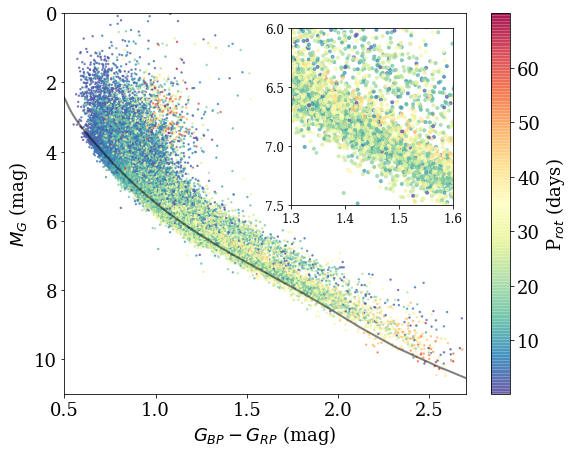

In [15]:
# plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

fig, ax1 = plt.subplots(figsize=(9,7))

plt.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=2, cmap=cm)

# plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], iso['Gmag'].values[iok], 
#          c='k', lw=2, alpha=0.25)

ax1.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.5)

plt.ylim(11,0)
plt.xlim(.5,2.7)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')


# left, bottom, width, height
ax2 = fig.add_axes([0.475, 0.5, 0.25, 0.35])
ax2.tick_params(labelsize=12)
ax2.scatter(df[u'bp_rp'].values[ok], 
            df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
            c=(df[u'Prot'].values[ok]), alpha=0.7, s=9, cmap=cm)

ax2.set_xlim(1.3,1.6)
ax2.set_ylim(7.5, 6)
ax2.set_yticks([7.5, 7, 6.5, 6])

plt.savefig('../figures/cmd'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

Now select things in a plausible main sequence region

In [16]:
# originally did it w/ Parsec
Mg_iso = np.interp(df[u'bp_rp'].values[ok], iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], 
                   iso['Gmag'].values[iok])
delta_mag = Mg_iso - (df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5)


# but now I like MIST better for this I think
Mg_iso_mist = np.interp(df[u'bp_rp'].values[ok], mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
                        mist['Gaia_G_DR2Rev'].values[mist_ms1])

delta_mag_mist = Mg_iso_mist - (df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5)

In [17]:
# dok = np.isfinite(delta_mag)

# dmag_lims = [[0.2, 0.6], [0.8, 1.3]]

# # main sequence stars
# msok = np.where((delta_mag >= dmag_lims[0][0]) & 
#                 (delta_mag <= dmag_lims[0][1]))[0]

(16248,)


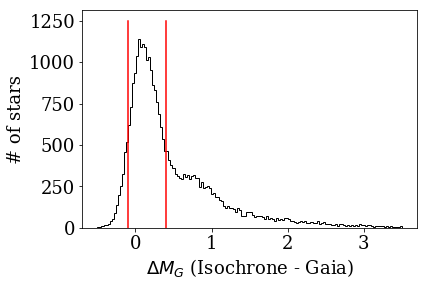

In [18]:
dok = np.isfinite(delta_mag_mist)
dmag_lims = [[-0.1, 0.4], [0.5, 1.]]

# main sequence stars
msok = np.where((delta_mag_mist >= dmag_lims[0][0]) & 
                (delta_mag_mist <= dmag_lims[0][1]))[0]

print(msok.shape)

_ = plt.hist(delta_mag_mist[dok], range=(-0.5,3.5), bins=150, histtype='step', lw=1, color='k')
plt.ylabel('# of stars')
plt.xlabel(r'$\Delta M_G$ (Isochrone - Gaia)')

plt.plot([dmag_lims[0][0],dmag_lims[0][0]], [0,1250], c='r')
plt.plot([dmag_lims[0][1],dmag_lims[0][1]], [0,1250], c='r')

# plt.plot([dmag_lims[1][0],dmag_lims[1][0]], [0,1250], c='b', linestyle='--')
# plt.plot([dmag_lims[1][1],dmag_lims[1][1]], [0,1250], c='b', linestyle='--')

## KOIs? 
where do they fall on this diagram? any binary stars hosting? (evans2018)

In [19]:
koi_raw = pd.read_csv('../data/q1_q17_dr25_koi.csv', comment='#')

koi = pd.merge(df, koi_raw, right_on='kepid', left_on='kepid')
koi.shape

(339, 252)

In [20]:
koiok = np.where(np.isfinite(koi[u'parallax']) & # this is basically the same as the TGAS file...
                (koi[u'parallax_error'] < 0.1) &
                (gaia[u'r_modality_flag'] == 1) & 
                (gaia[u'r_result_flag'] == 1) &
                np.isfinite(koi[u'bp_rp']) & 
                (koi[u'phot_bp_mean_flux_error']/koi[u'phot_bp_mean_flux'] < 0.01) & 
                (koi[u'phot_rp_mean_flux_error']/koi[u'phot_rp_mean_flux'] < 0.01) & 
                (koi[u'phot_g_mean_flux_error']/koi[u'phot_g_mean_flux'] < 0.01))[0]
koiok.shape

(301,)

In [21]:
# plt.figure(figsize=(9,7))
# cm = plt.cm.get_cmap('Spectral_r')

# plt.scatter(df[u'bp_rp'].values[ok], 
#             df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok])  + 5, 
#             c=(df[u'Prot'].values[ok]), alpha=0.5, s=1, cmap=plt.cm.gray_r)

# plt.scatter(koi[u'bp_rp'].values[koiok], 
#             koi[u'phot_g_mean_mag'].values[koiok] - 5. * np.log10(koi[u'r_est'].values[koiok])  + 5, 
#             c=(koi[u'Prot'].values[koiok]), alpha=0.75, s=10, cmap=cm)


# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
#          mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=2, alpha=0.5)

# plt.ylim(11,0)
# plt.xlim(.5,2.7)
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.ylabel('$M_G$ (mag)')

# cb = plt.colorbar()
# cb.set_label('P$_{rot}$ (days)')

# plt.savefig('../figures/cmd_koi'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

## An interesting feature I noticed...
is there a gradient of rotation period across the main sequence? maybe binaries?

if so, we can get a sharper exploration of the bimodality by selecting only the "lower" bit...?

In [22]:
# iso_grid_file = '../iso/parsec/output918200599801.dat'
# inames = ('Zini','Age','Mini','Mass','logL','logTe','logg','label','McoreTP',
#             'C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo',
#             'Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag')
# igrid = pd.read_table(iso_grid_file, delim_whitespace=True, header=None, comment='#', names=inames)

# igok0 = np.where((igrid['label'] < 2) & (igrid['Age'] == 1e9))


In [23]:
# plt.figure(figsize=(16,7))
# cm = plt.cm.get_cmap('Spectral_r')


# crng = [1.25, 1.65]

# # i forget what rb stands for.... but its stuff near the main sequence in a small range of color
# rb_ok0 = np.where((df[u'bp_rp'].values[ok] > crng[0]) & (df[u'bp_rp'].values[ok] < crng[1]) & 
#                   (df[u'Prot'].values[ok] < 50))[0]

# plt.subplot(121)
# #----
# plt.scatter(df[u'bp_rp'].values[ok][rb_ok0], 
#             df[u'phot_g_mean_mag'].values[ok][rb_ok0] - 5. * np.log10(df[u'r_est'].values[ok][rb_ok0])  + 5, 
#             c=(df[u'Prot'].values[ok][rb_ok0]), 
#             alpha=0.75, s=25, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

# plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Gmag'].values[iok], 
#          c='k', lw=2, alpha=0.9)

# # plt.plot(igrid['G_BPmag'].values[igok0] - igrid['G_RPmag'].values[igok0], igrid['Gmag'].values[igok0],
# #          c='k', lw=2, alpha=0.8)

# # plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
# #          mist['Gaia_G_DR2Rev'].values[mist_ms1])

# plt.ylim(7.6,6)
# plt.xlim(crng[0], crng[1])
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.ylabel('$M_G$ (mag)')


# #----
# plt.subplot(122)
# rb_ok = np.where((df[u'bp_rp'].values[ok] > crng[0]) & (df[u'bp_rp'].values[ok] < crng[1]) & 
#                   (delta_mag > 0.1) & (delta_mag < 0.8))[0]

# plt.scatter(df[u'Prot'].values[ok][rb_ok], delta_mag[rb_ok], c=(df[u'Prot'].values[ok][rb_ok]),
#             s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

# dy = 5
# yy = np.arange(10,50,dy)
# xx = np.zeros_like(yy, dtype='float')
# xxe = np.zeros_like(yy, dtype='float')
# for k in range(len(yy)):
#     xok = np.where((df[u'Prot'].values[ok][rb_ok] >= yy[k]-dy/2.) & (df[u'Prot'].values[ok][rb_ok] < (yy[k]+dy/2.)))
#     xx[k] = np.nanmedian(delta_mag[rb_ok][xok])
#     xxe[k] = np.nanstd(delta_mag[rb_ok][xok]) 

# plt.errorbar(yy,xx, yerr=xxe, marker='s')

# plt.ylim(0.1, 0.8)
# plt.ylabel(r'$\Delta M_G$ (Isochrone - Gaia)')
# plt.xlabel('P$_{rot}$ (days)')

# plt.savefig('../figures/cmd_zoom'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

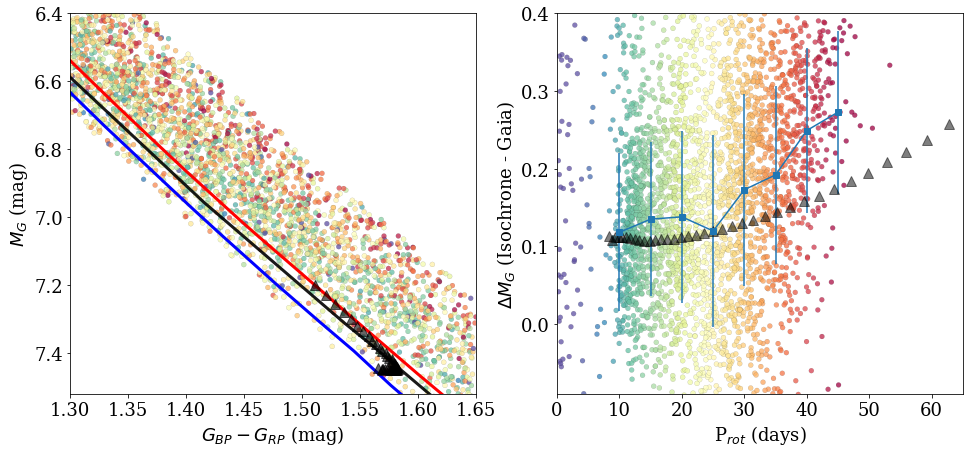

In [24]:
plt.figure(figsize=(16,7))
cm = plt.cm.get_cmap('Spectral_r')

crng = [1.3, 1.65]
cclim = [3, 45]

# i forget what rb stands for.... but its stuff near the main sequence in a small range of color
rb_ok0 = np.where((df[u'bp_rp'].values[ok][msok] > crng[0]) & 
                  (df[u'bp_rp'].values[ok][msok] < crng[1]) & 
                  (df[u'Prot'].values[ok][msok] < 70))[0]

plt.subplot(121)
#----
plt.scatter(df[u'bp_rp'].values[ok][msok][rb_ok0], 
            df[u'phot_g_mean_mag'].values[ok][msok][rb_ok0] - 5. * np.log10(df[u'r_est'].values[ok][msok][rb_ok0]) + 5, 
            c=(df[u'Prot'].values[ok][msok][rb_ok0]), 
            alpha=0.75, s=25, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

plt.clim(cclim[0], cclim[1])


# plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Gmag'].values[iok], 
#          c='k', lw=2, alpha=0.9)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=3, alpha=0.9)

# put down 2 MIST isochrones, 1e8 and 1e10 years for reference
Mist_ages = np.unique(mist['log10_isochrone_age_yr'].values)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=3, c='Blue')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=3, c='Red')


plt.ylim(7.52,6.4)
plt.xlim(crng[0], crng[1])
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')



M_point = 0.7 # M_solar

Mist_ages = np.unique(mist['log10_isochrone_age_yr'].values)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
#         lw=0.5, alpha=0.5, c='Blue')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
#         lw=0.5, alpha=0.5, c='k')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
#         lw=0.5, alpha=0.5, c='Red')

# mist
arng = np.where((mist['log10_isochrone_age_yr'] > 8) & (mist['log10_isochrone_age_yr'] <= 10) )
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_BR = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_BP_DR2Rev'].values[aok] - mist['Gaia_RP_DR2Rev'].values[aok])
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])

    plt.plot(new_BR, new_G, marker='^', c='k', alpha=0.6, zorder=3, markersize=10)


#----
plt.subplot(122)
rb_ok = np.where((df[u'bp_rp'].values[ok][msok] > crng[0]) & 
                 (df[u'bp_rp'].values[ok][msok] < crng[1]) & 
                 (delta_mag_mist[msok] > -0.1) & 
                 (delta_mag_mist[msok] < 0.6))[0]

plt.scatter(df[u'Prot'].values[ok][msok][rb_ok], delta_mag_mist[msok][rb_ok], 
            c=(df[u'Prot'].values[ok][msok][rb_ok]),
            s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)
plt.clim(cclim[0], cclim[1])

dy = 5
yy = np.arange(10,50,dy)
xx = np.zeros_like(yy, dtype='float')
xxe = np.zeros_like(yy, dtype='float')
for k in range(len(yy)):
    xok = np.where((df[u'Prot'].values[ok][msok][rb_ok] >= yy[k]-dy/2.) & 
                   (df[u'Prot'].values[ok][msok][rb_ok] < (yy[k]+dy/2.)))
    xx[k] = np.nanmedian(delta_mag_mist[msok][rb_ok][xok])
    xxe[k] = np.nanstd(delta_mag_mist[msok][rb_ok][xok]) 

plt.errorbar(yy,xx, yerr=xxe, marker='s')

BV07 = 1.126 #B-V color of a 0.7Msun star, from isochrone way below in notebook
new_G0 = 7.4379784040958405
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])
    plt.plot(MM09e2(BV07, (10.**aa)/1e6), new_G0 - new_G+0.12, marker='^', c='k', alpha=0.5, zorder=2, markersize=10)
    
plt.xlim(0, 65)
plt.ylim(-0.09, 0.4)
plt.ylabel(r'$\Delta M_G$ (Isochrone - Gaia)')
plt.xlabel('P$_{rot}$ (days)')

# plt.savefig('../figures/cmd_zoom'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [63]:
# do Delta Color
bprp_iso_mist = np.interp((df[u'phot_g_mean_mag'].values[ok] - 5. * np.log10(df[u'r_est'].values[ok]) + 5), 
                          mist['Gaia_G_DR2Rev'].values[mist_ms1], 
                          mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1])

# df[u'bp_rp'].values[ok], 
# mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
# mist['Gaia_G_DR2Rev'].values[mist_ms1]

delta_bprp_mist = df[u'bp_rp'].values[ok] - bprp_iso_mist

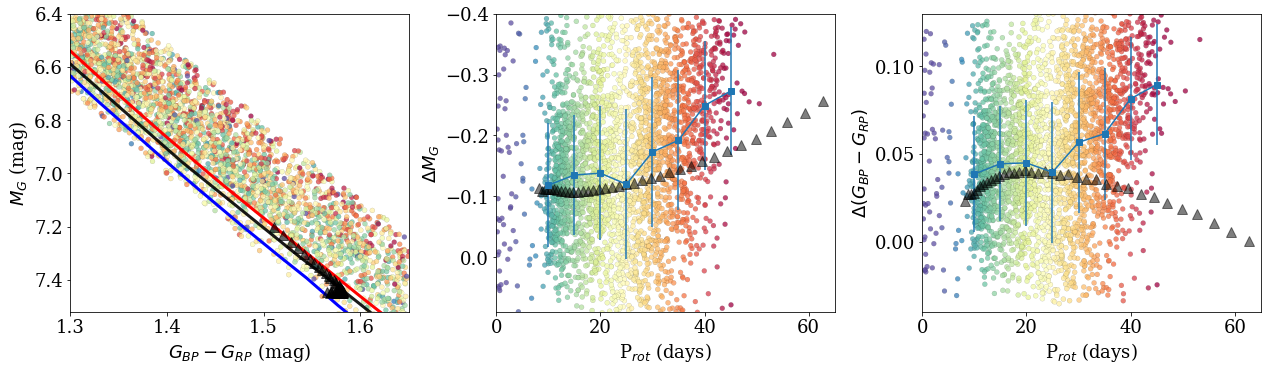

In [80]:
plt.figure(figsize=(18,5.5))
cm = plt.cm.get_cmap('Spectral_r')

crng = [1.3, 1.65]
cclim = [3, 45]

# i forget what rb stands for.... but its stuff near the main sequence in a small range of color
rb_ok0 = np.where((df[u'bp_rp'].values[ok][msok] > crng[0]) & 
                  (df[u'bp_rp'].values[ok][msok] < crng[1]) & 
                  (df[u'Prot'].values[ok][msok] < 70))[0]

plt.subplot(131)
#----
plt.scatter(df[u'bp_rp'].values[ok][msok][rb_ok0], 
            df[u'phot_g_mean_mag'].values[ok][msok][rb_ok0] - 5. * np.log10(df[u'r_est'].values[ok][msok][rb_ok0]) + 5, 
            c=(df[u'Prot'].values[ok][msok][rb_ok0]), 
            alpha=0.75, s=25, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

plt.clim(cclim[0], cclim[1])


# plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Gmag'].values[iok], 
#          c='k', lw=2, alpha=0.9)

plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
         mist['Gaia_G_DR2Rev'].values[mist_ms1], c='k', lw=3, alpha=0.9)

# put down 2 MIST isochrones, 1e8 and 1e10 years for reference
Mist_ages = np.unique(mist['log10_isochrone_age_yr'].values)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=3, c='Blue')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=3, c='Red')


plt.ylim(7.52,6.4)
plt.xlim(crng[0], crng[1])
plt.xticks([1.3, 1.4, 1.5, 1.6])
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')



M_point = 0.7 # M_solar

Mist_ages = np.unique(mist['log10_isochrone_age_yr'].values)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
#         lw=0.5, alpha=0.5, c='Blue')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
#         lw=0.5, alpha=0.5, c='k')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
# plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
#         lw=0.5, alpha=0.5, c='Red')

# mist
arng = np.where((mist['log10_isochrone_age_yr'] > 8) & (mist['log10_isochrone_age_yr'] <= 10) )
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_BR = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_BP_DR2Rev'].values[aok] - mist['Gaia_RP_DR2Rev'].values[aok])
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])

    plt.plot(new_BR, new_G, marker='^', c='k', alpha=0.6, zorder=3, markersize=10)


#----
plt.subplot(132)
rb_ok = np.where((df[u'bp_rp'].values[ok][msok] > crng[0]) & 
                 (df[u'bp_rp'].values[ok][msok] < crng[1]) & 
                 (delta_mag_mist[msok] > -0.1) & 
                 (delta_mag_mist[msok] < 0.6))[0]

plt.scatter(df[u'Prot'].values[ok][msok][rb_ok], -delta_mag_mist[msok][rb_ok], 
            c=(df[u'Prot'].values[ok][msok][rb_ok]),
            s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)
plt.clim(cclim[0], cclim[1])

dy = 5
yy = np.arange(10,50,dy)
xx = np.zeros_like(yy, dtype='float')
xxe = np.zeros_like(yy, dtype='float')
for k in range(len(yy)):
    xok = np.where((df[u'Prot'].values[ok][msok][rb_ok] >= yy[k]-dy/2.) & 
                   (df[u'Prot'].values[ok][msok][rb_ok] < (yy[k]+dy/2.)))
    xx[k] = np.nanmedian(delta_mag_mist[msok][rb_ok][xok])
    xxe[k] = np.nanstd(delta_mag_mist[msok][rb_ok][xok]) 

plt.errorbar(yy,-xx, yerr=xxe, marker='s')

BV07 = 1.126 #B-V color of a 0.7Msun star, from isochrone way below in notebook
new_G0 = 7.4379784040958405
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])
    plt.plot(MM09e2(BV07, (10.**aa)/1e6), -(new_G0 - new_G+0.12), marker='^', 
             c='k', alpha=0.5, zorder=2, markersize=10)
    
plt.xlim(0, 65)
plt.ylim(0.09, -0.4)
plt.ylabel(r'$\Delta M_G$')
plt.xlabel('P$_{rot}$ (days)')


#----
plt.subplot(133)
plt.scatter(df[u'Prot'].values[ok][msok][rb_ok], delta_bprp_mist[msok][rb_ok], 
            c=(df[u'Prot'].values[ok][msok][rb_ok]),
            s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)
plt.clim(cclim[0], cclim[1])

dy = 5
yy = np.arange(10,50,dy)
xx = np.zeros_like(yy, dtype='float')
xxe = np.zeros_like(yy, dtype='float')
for k in range(len(yy)):
    xok = np.where((df[u'Prot'].values[ok][msok][rb_ok] >= yy[k]-dy/2.) & 
                   (df[u'Prot'].values[ok][msok][rb_ok] < (yy[k]+dy/2.)))
    xx[k] = np.nanmedian(delta_bprp_mist[msok][rb_ok][xok])
    xxe[k] = np.nanstd(delta_bprp_mist[msok][rb_ok][xok]) 

plt.errorbar(yy,xx, yerr=xxe, marker='s')

new_bprp0 = 1.5818970089821143
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_bprp = np.interp(M_point, mist['star_mass'].values[aok], 
                         mist['Gaia_BP_DR2Rev'].values[aok] - mist['Gaia_RP_DR2Rev'].values[aok])
#     print(aa, new_bprp)
    plt.plot(MM09e2(BV07, (10.**aa)/1e6), (new_bprp-new_bprp0+0.04), marker='^', 
             c='k', alpha=0.5, zorder=2, markersize=10)

plt.ylabel(r'$\Delta (G_{BP}-G_{RP})$')
plt.xlabel('P$_{rot}$ (days)')
plt.ylim(-0.04, 0.13)
plt.yticks([0, 0.05, 0.1])
plt.xlim(0, 65)

plt.tight_layout(w_pad=0.5)
plt.savefig('../figures/cmd_zoom'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

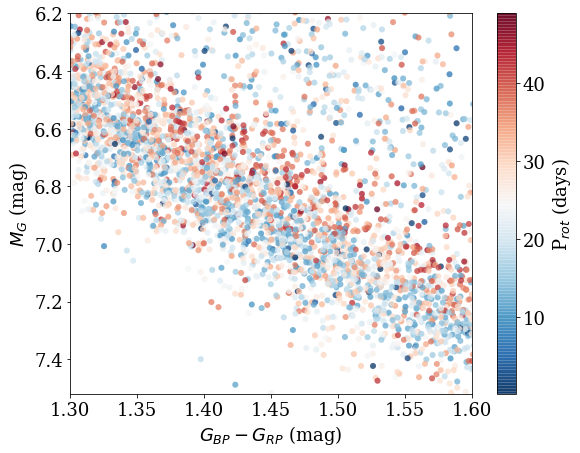

In [25]:
plt.figure(figsize=(9,7))


rb_ok0 = np.where((df[u'bp_rp'].values[ok] > crng[0]) & (df[u'bp_rp'].values[ok] < crng[1]) & 
                  (df[u'Prot'].values[ok] < 50))[0]
#----
plt.scatter(df[u'bp_rp'].values[ok][rb_ok0], 
            df[u'phot_g_mean_mag'].values[ok][rb_ok0] - 5. * np.log10(df[u'r_est'].values[ok][rb_ok0])  + 5, 
            c=(df[u'Prot'].values[ok][rb_ok0]),
            alpha=0.75, s=35, cmap=plt.cm.RdBu_r, edgecolors=None, lw=0.1, rasterized=False)

plt.ylim(7.52,6.2)
plt.xlim(1.3,1.6)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')

cb = plt.colorbar()
cb.set_label('P$_{rot}$ (days)')

plt.savefig('../figures/cmd_zoom_plain.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [26]:
print(max(xx) - min(xx),' mag' )

(0.15466196354384465, ' mag')


In [27]:
# # how much change in mag do we expect from a grid of isochrones (not correcting for offsets)

# newMg0 = 7.34344444 # found this manually the first time for the youngest age

# color_point = (crng[0] + crng[1])/2.
# for aa in np.unique(igrid['Age']):
#     aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
#     newMg = np.interp(color_point, igrid['G_BPmag'].values[aok] - 
#                       igrid['G_RPmag'].values[aok], igrid['Gmag'].values[aok])
# #     print(aa, newMg)
#     plt.scatter(aa, newMg0 - newMg,
#                c='k')
# #     plt.plot(igrid['G_BPmag'].values[aok] - igrid['G_RPmag'].values[aok], igrid['Gmag'].values[aok], '-o', alpha=0.1)

# plt.xscale('log')
# plt.xlabel('Age (years)')
# plt.ylabel(r'$\Delta M_G$ ')
# # plt.savefig('../figures/iso_age'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [28]:
# # interesting difference in mass versus color... probably from [Fe/H] differences

# plt.plot(mist['Gaia_BP_DR2Rev'].values[mist_ms1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1], 
#          mist['star_mass'].values[mist_ms1],'-s', label='MIST 1e9', c='k')

# plt.plot(iso5e9['G_BPmag'].values[iok] - iso5e9['G_RPmag'].values[iok], iso5e9['Mass'].values[iok],
#         '-o', label='PARSEC 5e9', c='r')

# plt.legend(fontsize=10)
# plt.ylim(.61,.82)
# plt.xlim(crng[0], crng[1])
# plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
# plt.ylabel('mass (solar)')

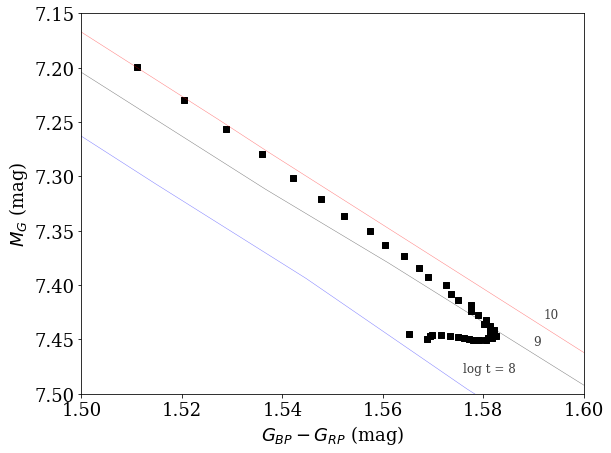

In [29]:
# track a given mass in Delta Mag in all isochrone flavors
plt.figure(figsize=(9,7))
cm = plt.cm.get_cmap('Spectral_r')

M_point = 0.7 # M_solar
# plt.subplot(121) # plot the CMD

# put down 2 MIST isochrones, 1e8 and 1e10 years for reference
Mist_ages = np.unique(mist['log10_isochrone_age_yr'].values)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=0.5, alpha=0.5, c='Blue')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=0.5, alpha=0.5, c='k')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
        lw=0.5, alpha=0.5, c='Red')


# mist
arng = np.where((mist['log10_isochrone_age_yr'] >= 7.95) & (mist['log10_isochrone_age_yr'] <= 10) )
for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
    aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
    new_BR = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_BP_DR2Rev'].values[aok] - mist['Gaia_RP_DR2Rev'].values[aok])
    new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                      mist['Gaia_G_DR2Rev'].values[aok])

    plt.scatter(new_BR, new_G, marker='s', c='k')

# parsec
# for aa in np.unique(igrid['Age']):
#     aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
#     new_BR = np.interp(M_point, igrid['Mass'].values[aok], igrid['G_BPmag'].values[aok] - igrid['G_RPmag'].values[aok])
#     new_G = np.interp(M_point, igrid['Mass'].values[aok], igrid['Gmag'].values[aok])

#     plt.scatter(new_BR, new_G, marker='o', c='r')

plt.ylim(7.5, 7.15)
plt.xlim(1.5, 1.6)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')



# plt.subplot(122)
# ## MIST
# new_G0 = 7.44941668207 # found manually the first time
# arng = np.where((mist['log10_isochrone_age_yr'] > 8.1) & (mist['log10_isochrone_age_yr'] <= 10) )
# for aa in np.unique(mist['log10_isochrone_age_yr'].values[arng]):
#     aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
#     new_G = np.interp(M_point, mist['star_mass'].values[aok], 
#                       mist['Gaia_G_DR2Rev'].values[aok])
#     plt.scatter(aa, new_G-new_G0, marker='s', c='k')

    
# ## PARSEC
# new_G0 = 6.6320 # found manually the first time
# for k in range(0,len(np.unique(igrid['Age'])),3):
#     aa = np.unique(igrid['Age'])[k]
#     aok = np.where((igrid['Age'] == aa) & (igrid['label'] < 2) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values >= crng[0]) & 
#                    (igrid['G_BPmag'].values - igrid['G_RPmag'].values < crng[1]))[0][::-1]
#     new_G = np.interp(M_point, igrid['Mini'].values[aok], igrid['Gmag'].values[aok])


# plt.ylim(0.01, -0.3)
# plt.yticks((0, -0.1, -0.2, -0.3))
# plt.xlabel('log age (yrs)')
# plt.ylabel(r'$\Delta M_G$ ')

plt.text(1.576, 7.48, 'log t = 8', fontsize=12, color='k', alpha=0.75)
plt.text(1.59, 7.455, '9', fontsize=12, color='k', alpha=0.75)
plt.text(1.592, 7.43, '10', fontsize=12, color='k', alpha=0.75)
plt.savefig('../figures/cmd_evol_1star'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

Text(0.5,1,'MIST isochrones')

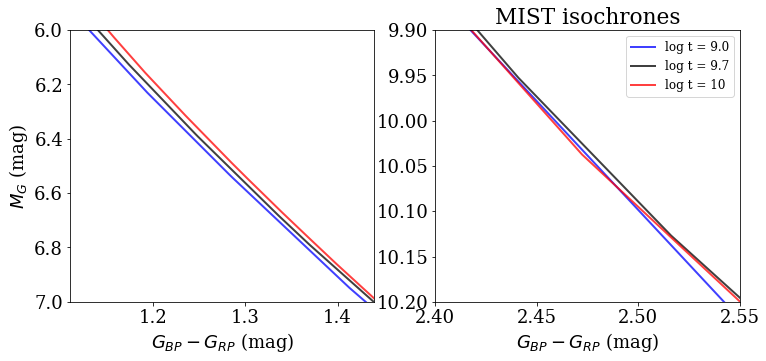

In [30]:
#MIST isochrones
plt.figure(figsize=(12,5))

plt.subplot(121)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=2, alpha=0.75, c='Blue', label='log t = 9.0')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[94]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=2, alpha=0.75, c='k', label='log t = 9.7')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
        lw=2, alpha=0.75, c='Red', label='log t = 10')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.ylim(7,6)
plt.xlim(1.11,1.44)

plt.subplot(122)
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=2, alpha=0.75, c='Blue', label='log t = 9.0')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[94]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=2, alpha=0.75, c='k', label='log t = 9.7')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
        lw=2, alpha=0.75, c='Red', label='log t = 10')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylim(10.2, 9.9)
plt.xlim(2.4, 2.55)
plt.legend(fontsize=12)
plt.title('MIST isochrones')

Text(0.5,1,'MIST isochrones')

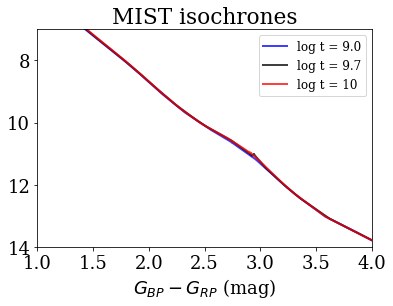

In [31]:
m1 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m1] - mist['Gaia_RP_DR2Rev'].values[m1], mist['Gaia_G_DR2Rev'].values[m1],
        lw=2, alpha=0.75, c='Blue', label='log t = 9.0')

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[94]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2] - mist['Gaia_RP_DR2Rev'].values[m2], mist['Gaia_G_DR2Rev'].values[m2],
        lw=2, alpha=0.75, c='k', label='log t = 9.7')

m3 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[100]) & (mist['Gaia_G_DR2Rev'] > 2))
plt.plot(mist['Gaia_BP_DR2Rev'].values[m3] - mist['Gaia_RP_DR2Rev'].values[m3], mist['Gaia_G_DR2Rev'].values[m3],
        lw=2, alpha=0.75, c='Red', label='log t = 10')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylim(14,7)
plt.xlim(1, 4)
plt.legend(fontsize=12)
plt.title('MIST isochrones')

## The Color-Rotation Diagram
This is the meat of what we're after!

The period bimodality *is* there, and most notable for the red stars again.

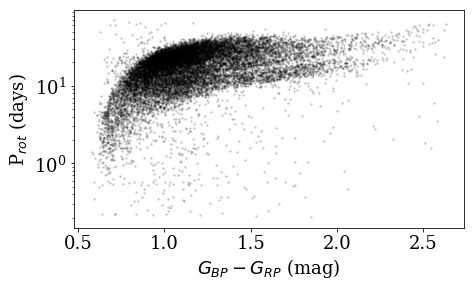

In [32]:
plt.figure(figsize=(7,4))
cm = plt.cm.get_cmap('Spectral')

plt.scatter(df[u'bp_rp'].values[ok][msok], df[u'Prot'].values[ok][msok], 
            s=5, alpha=0.25, c='k', lw=0)

plt.yscale('log')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('P$_{rot}$ (days)');

In [33]:
# plt.figure(figsize=(7,4))
# cm = plt.cm.get_cmap('Spectral')

# plt.scatter(df[u'Teff'].values[ok][msok], df[u'Prot'].values[ok][msok], 
#             s=5, alpha=0.25, c='k', lw=0, rasterized=True)

# plt.yscale('log')
# plt.xlabel('Teff (K)')
# plt.xlim(6600,3000)
# plt.ylabel('P$_{rot}$ (days)')

In [34]:
# plt.figure(figsize=(7,4))
# cm = plt.cm.get_cmap('Spectral')

# plt.scatter(df[u'jmag'].values[ok][msok] - df[u'kmag'].values[ok][msok] , df[u'Prot'].values[ok][msok], 
#             s=5, alpha=0.25, c='k', lw=0, rasterized=True)

# plt.yscale('log')
# plt.xlabel('J-Ks')
# plt.xlim(0.15,1)
# plt.ylabel('P$_{rot}$ (days)')

## Slices in Distance
This is *messier* than with DR1, likely because we're not just limited to the nearest 300pc!

So do what I said I'd do in the DR1 paper... make cuts in distance

In [35]:
dist = df[u'r_est'].values[ok][msok]

# _ = plt.hist(dist, histtype='step', color='k', bins=100)
# plt.xlabel('Dist (pc)')
# plt.ylabel('Number of Stars')

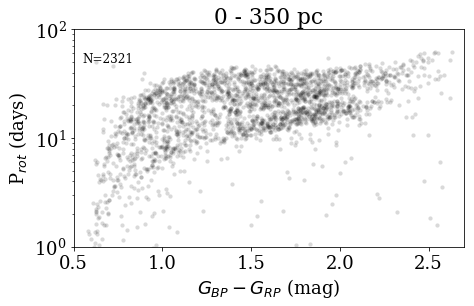

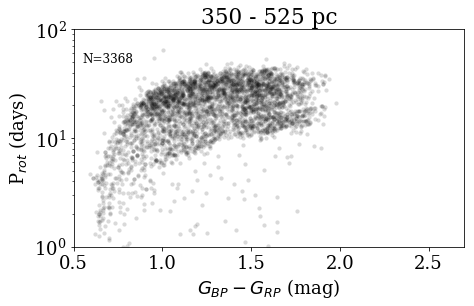

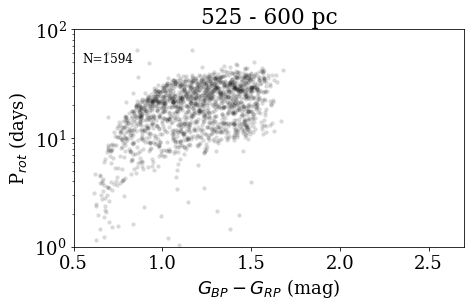

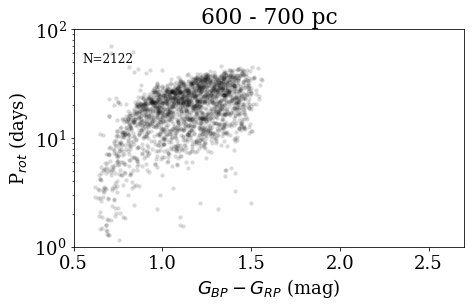

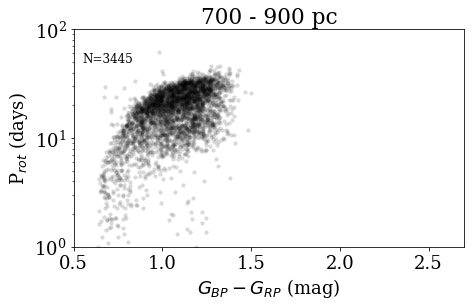

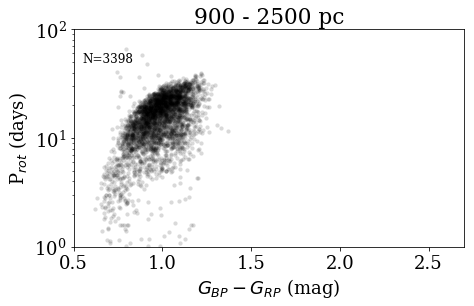

In [36]:
# dbins = np.array([0, 300, 450, 525, 600, 700, 800, 900, 1100, 3500])
dbins = np.array([0, 350, 525, 600, 700, 900, 2500])

for k in range(len(dbins)-1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))
    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'Prot'].values[ok][msok][dd], 
                s=18, alpha=0.15, c='k', lw=0, rasterized=False)
    
    plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    plt.yscale('log')
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(0.5,2.7)
    plt.ylim(1,100)
    plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
    plt.savefig('../figures/rot_dist_'+str(dbins[k]) + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
    plt.show()

## a KDE aside...

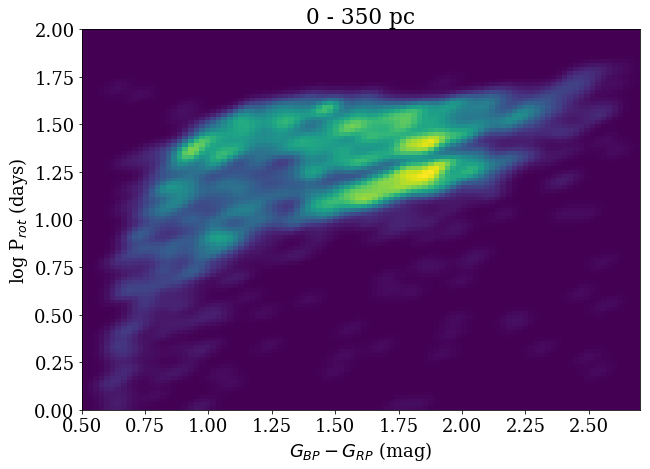

In [37]:
from scipy import stats

dbins = np.array([0, 350, 525, 600, 700, 900, 2500])
k=0
dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))


X, Y = np.mgrid[0.5:2.7:100j, 0:2:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([df[u'bp_rp'].values[ok][msok][dd], np.log10(df[u'Prot'].values[ok][msok][dd])])
kernel = stats.gaussian_kde(values)
kernel.set_bandwidth(bw_method=kernel.factor / 3.)
Z = np.reshape(kernel(positions).T, X.shape)

plt.figure(figsize=(10,7))
plt.imshow(np.rot90(Z), extent=[0.5, 2.7, 0, 2],aspect='auto')#, cmap=plt.cm.magma)
# plt.scatter(df[u'bp_rp'].values[ok][msok][dd], np.log10(df[u'Prot'].values[ok][msok][dd]), 
#             s=18, alpha=0.15, c='k', lw=0)

# plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
# plt.yscale('log')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('log P$_{rot}$ (days)');
plt.xlim(0.5,2.7)
plt.ylim(0,2)
plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
# plt.savefig('../figures/rot_dist_'+str(dbins[k]) + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
plt.show()

## NGC 6811?

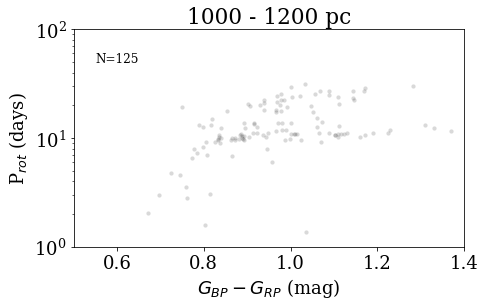

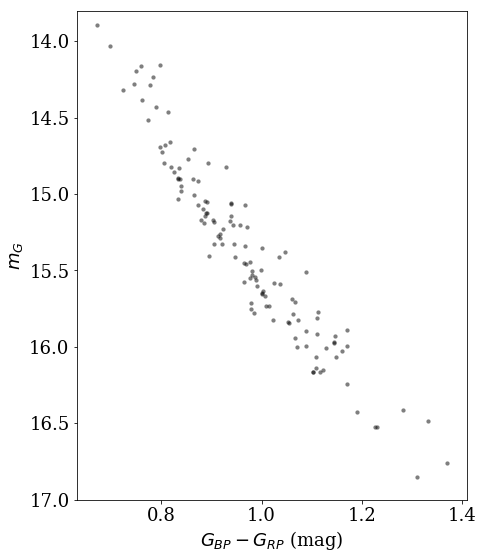

In [38]:
# dbins = np.array([0, 300, 450, 525, 600, 700, 800, 900, 1100, 3500])
dbins = np.array([1000, 1200])

for k in range(len(dbins)-1):
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) & 
                  (df[u'ra'].values[ok][msok] > 294) & 
                  (df[u'ra'].values[ok][msok] < 296) & 
                  (df[u'dec'].values[ok][msok] > 45) & 
                  (df[u'dec'].values[ok][msok] < 47))

    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'Prot'].values[ok][msok][dd], 
                s=18, alpha=0.15, c='k', lw=0, rasterized=False)
    
    plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    plt.yscale('log')
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(0.5,1.4)
    plt.ylim(1,100)
    plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
#     plt.savefig('../figures/rot_dist_'+str(dbins[k]) + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
    plt.show()
    
    
#     plt.figure(figsize=(7,7))
#     plt.scatter(df[u'ra'].values[ok][msok][dd],df[u'dec'].values[ok][msok][dd], 
#                 s=18, alpha=0.15, c='k', lw=0, rasterized=False)
#     plt.xlabel('RA')
#     plt.ylabel('DEC')
#     plt.show()
    
    
    plt.figure(figsize=(7,9))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'phot_g_mean_mag'].values[ok][msok][dd],
                s=18, alpha=0.5, c='k', lw=0, rasterized=False)
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('$m_G$')
    plt.ylim(17,13.8)
    plt.show()

In [39]:
# dbins = np.array([0, 300, 450, 600, 900, 1100, 3500])
# clr = ['DarkRed', 'red', 'salmon', 'RebeccaPurple', 'RoyalBlue', 'Navy']

# plt.figure(figsize=(7,5))

# for k in range(0,len(dbins)-1,1):
#     dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) & 
#                   (df[u'bp_rp'].values[ok][msok] >= 1) & (df[u'bp_rp'].values[ok][msok] <= 1.2))
    
    
#     _ = plt.hist((df[u'Prot'].values[ok][msok][dd]), histtype='step', bins=25,
#                  label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc', 
#                  normed=True, lw=2, alpha=0.5, color=clr[k])
# plt.legend()
# plt.title('1 < $G_{BP} - G_{RP}$ < 1.2')
# plt.ylabel('Fraction of Stars')
# plt.xlabel('P$_{rot}$ (days)')

(0, 1500)

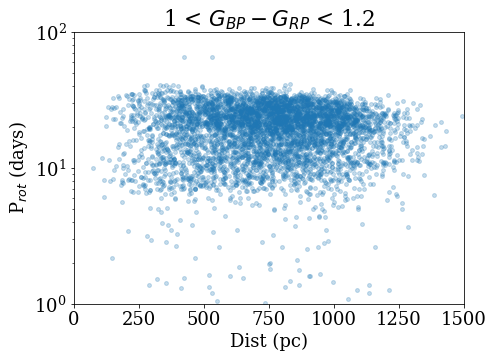

In [40]:
dd = np.where((df[u'bp_rp'].values[ok][msok] >= 1.) & (df[u'bp_rp'].values[ok][msok] <= 1.2))

plt.figure(figsize=(7,5))
plt.scatter(dist[dd], (df[u'Prot'].values[ok][msok][dd]), alpha=0.25, s=15)
plt.yscale('log')
plt.title('1 < $G_{BP} - G_{RP}$ < 1.2')
plt.ylabel('P$_{rot}$ (days)')
plt.xlabel('Dist (pc)')
plt.ylim(1,100)
plt.xlim(0,1500)

In [41]:
# the B-V color of a 0.7 solar mass star... used way above
iso2['Bmag'].values[23] - iso2['Vmag'].values[23]

1.1260000000000003

Text(0.5,1,'1e9yr isochrone')

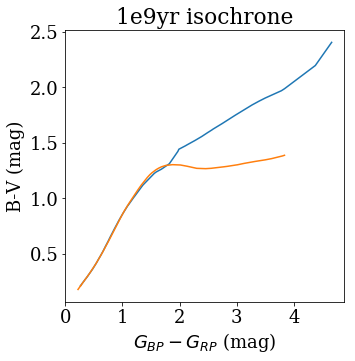

In [42]:
M_point = 0.7

plt.figure(figsize=(5,5))
plt.plot(iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok], 
         iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok])

m2b = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[60]) & (mist['Gaia_G_DR2Rev'] > 2) & 
              (mist['Gaia_BP_DR2Rev'] - mist['Gaia_RP_DR2Rev'] > 0))[0][::-1]

# plt.plot(mist['Gaia_BP_DR2Rev'].values[m2b] - mist['Gaia_RP_DR2Rev'].values[m2b],
#          mist['Tycho_B'].values[m2b] - mist['Tycho_V'].values[m2b])
plt.plot(mist['Gaia_BP_DR2Rev'].values[m2b] - mist['Gaia_RP_DR2Rev'].values[m2b],
         mist['Bessell_B'].values[m2b] - mist['Bessell_V'].values[m2b])


plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('B-V (mag)')
plt.title('1e9yr isochrone')

In [43]:
# now convert these gyrochrones from B-V to GP-RP, or our data to B-V (via an isochrone)
BV_ms = np.interp(df[u'bp_rp'].values[ok], iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok],
                 iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok])

## i *would* use a MIST isochrone, but the B-V color doesnt look good for lower MS....crunches the red
# BV_ms = np.interp(df[u'bp_rp'].values[ok], mist['Gaia_BP_DR2Rev'].values[m2b] - mist['Gaia_RP_DR2Rev'].values[m2b],
#                  mist['Bessell_B'].values[m2b] - mist['Bessell_V'].values[m2b])

In [44]:
# dbins = np.array([0, 350, 525, 600, 900, 3500])

# for k in range(len(dbins)-1):
#     dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))
    
#     plt.figure(figsize=(7,4))
#     plt.scatter(BV_ms[msok][dd], df[u'Prot'].values[ok][msok][dd], 
#                 s=18, alpha=0.25, c='k', lw=0)
    
#     B_V_iso = np.arange(0.55,1.8,0.01)

#     P_iso2 = MM09e2(B_V_iso, 600)
#     plt.plot(B_V_iso, P_iso2, c='red')

#     plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
#     plt.yscale('log')
#     plt.xlabel('B-V (mag)')
#     plt.ylabel('P$_{rot}$ (days)');
#     plt.xlim(0.4,1.8)
#     plt.ylim(1,100)
#     plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
#     plt.show()

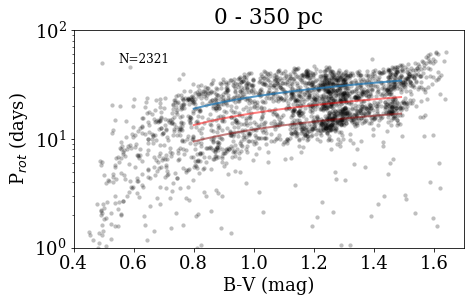

In [45]:
dbins = np.array([0, 350, 525, 600, 900, 3500])

k=0
dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]))

plt.figure(figsize=(7,4))
plt.scatter(BV_ms[msok][dd], df[u'Prot'].values[ok][msok][dd], 
            s=18, alpha=0.25, c='k', lw=0)

B_V_iso = np.arange(0.8,1.5,0.01)

P_iso1 = MM09e2(B_V_iso, 300)
P_iso2 = MM09e2(B_V_iso, 600)
P_iso3 = MM09e2(B_V_iso, 1200)
plt.plot(B_V_iso, P_iso1, c='DarkRed', lw=2, alpha=0.5)
plt.plot(B_V_iso, P_iso2, c='red', lw=2, alpha=0.5)
plt.plot(B_V_iso, P_iso3, lw=2, alpha=0.75)


plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
plt.yscale('log')
plt.xlabel('B-V (mag)')
plt.ylabel('P$_{rot}$ (days)');
plt.xlim(0.4,1.7)
plt.ylim(1,100)
plt.title(str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
plt.savefig('../figures/B_V_rot' + ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [46]:
# convert the B-V limits to Gaia colors for refernece
print(np.interp([0.8, 1.5], iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok],
                iso['G_BPmag'].values[iok] - iso['G_RPmag'].values[iok]))

print(np.interp([0.8, 1.5], iso2['Bmag'].values[iok] - iso2['Vmag'].values[iok],
                iso['Mass'].values[iok]))

[0.93668571 2.19294737]
[0.89571429 0.47763158]


/Users/james/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


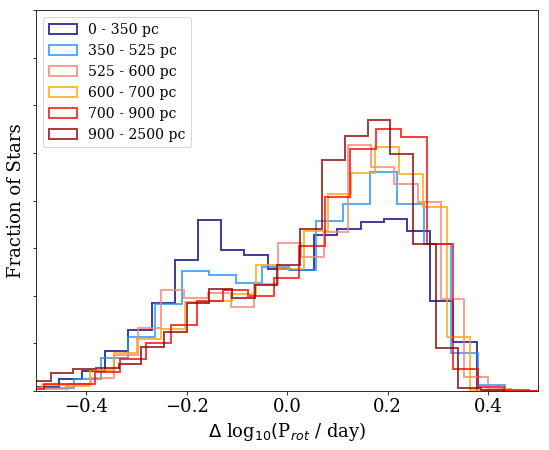

In [47]:
# dbins = np.array([0, 350, 525, 600, 900, 3500])

dbins = np.array([0, 350, 525, 600, 700, 900, 2500])
clr = ['DarkRed', 'red', 'orange', 'salmon', 'DodgerBlue', 'Navy']

fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
for k in range(len(dbins)-1):
    # for a restricted range of color (0.7 < B-V < 1.5), subtract off 600Myr gyrochrone
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) &
                  (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.5))
     
    B_V_iso = np.arange(0.55,1.8,0.01)
    P_iso = MM09e2(B_V_iso, 600)
    plt.plot(B_V_iso, P_iso, c='r')

    rs = np.argsort(P_iso)
    red_P = np.interp(BV_ms[msok][dd], B_V_iso[rs], P_iso[rs])

    _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][dd]) - np.log10(red_P),
                 histtype='step', bins=50, lw=2, alpha=0.75, color=clr[::-1][k], normed=True,
                 label=str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')

plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,4)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')

plt.savefig('../figures/delta_per'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

In [48]:
# compute the approximate height above the Galactic mid-plane, in pc. 
# Assume Sun is ~20pc above the midplane... http://adsabs.harvard.edu/full/1995AJ....110.2183H

b = 13.5 * np.pi/180. # approx galactic lat of the Kepler field, in radians
dbins = np.array([0, 350, 525, 600, 700, 900, 2500])
print(dbins[1:] * np.sin(b) + 20)

[101.70587735 142.55881602 160.06721831 183.4117547  230.10082747
 603.61340964]


In [49]:
def _gaus1(x, a1, x1, sig1):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)))
    return f

def _gaus2(x, a1, x1, sig1, a2, x2, sig2):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)) + 
         a2 * np.exp(-(x - x2)**2 / (2 * sig2**2)) )
    return f

def _gaus3(x, a1, x1, sig1, a2, x2, sig2, a3, x3, sig3):
    """
    simple function for 2 gaussians
    """
    f = (a1 * np.exp(-(x - x1)**2 / (2 * sig1**2)) + 
         a2 * np.exp(-(x - x2)**2 / (2 * sig2**2)) +
         a3 * np.exp(-(x - x3)**2 / (2 * sig3**2)))
    return f

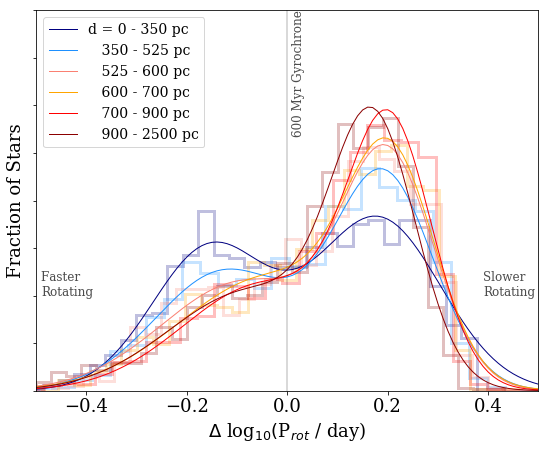

In [50]:
NBINS = 75

# dbins = np.array([0, 350, 525, 600, 900, 3500])

dbins = np.array([0, 350, 525, 600, 700, 900, 2500])
clr = ['DarkRed', 'red', 'orange', 'salmon', 'DodgerBlue', 'Navy']


fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
p2 = [32, -0.2, 0.01, 45, 0.2, 0.01]
ltmp = 'd = '
for k in range(len(dbins)-1):
    # for a restricted range of color, subtract off 600Myr gyrochrone
    dd = np.where((dist >= dbins[k]) & (dist < dbins[k+1]) &
                  (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))
     
    B_V_iso = np.arange(0.55,1.8,0.01)
    P_iso = MM09e2(B_V_iso, 600)
    plt.plot(B_V_iso, P_iso, c='r')

    rs = np.argsort(P_iso)
    red_P = np.interp(BV_ms[msok][dd], B_V_iso[rs], P_iso[rs])

    yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][dd]) - np.log10(red_P),
                        histtype='step', bins=NBINS, lw=3, alpha=0.25, color=clr[::-1][k], normed=True)

    
    bcent = (xx[:-1] + xx[1:])/2.
    
    
    popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
    perr2 = np.sqrt(np.diag(pcov2))

    dprot = np.arange(-1,1,0.01)
    plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c=clr[::-1][k], 
             label=ltmp + str(dbins[k]) + ' - ' + str(dbins[k+1]) + ' pc')
    ltmp = '   '
#     print(str(dbins[k]) + '-' + str(dbins[k+1]) + ' pc')
#     print(popt2)
#     print(perr2)
#     print()
    p2 = popt2
    
plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,4)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')

# add some annotations
plt.text(-0.49,1,'Faster \nRotating', fontsize=12, alpha=0.7)
plt.text(0.39,1,'Slower \nRotating', fontsize=12, alpha=0.7)
plt.plot([0,0], [0,4], alpha=0.2, c='k')
plt.text(0.01, 3.9, '600 Myr Gyrochrone', fontsize=12, alpha=0.7,rotation=90)

plt.savefig('../figures/delta_per_2gauss'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

## Galactocentric Coordinates...
are we seeing dropoff with height, or with projected distance? (i.e. a bubble or a gradient)

Can we tell?

In [51]:
import astropy.units as u
import astropy.coordinates as coord

c = coord.ICRS(ra = df[u'ra'].values[ok][msok] * u.degree, 
               dec = df[u'dec'].values[ok][msok] * u.degree, distance=dist*u.pc)
XYZ = c.transform_to(coord.Galactocentric)
XYZ.z # pretty rendering

<Quantity [ 82.73305506,  74.84543682, 103.46057807, ..., 220.33840059,
           300.47992373, 298.36317211] pc>

In [52]:
# this is how you actually get the values
XYZ.z.value < 100

array([ True,  True, False, ..., False, False, False])

(0, 500)

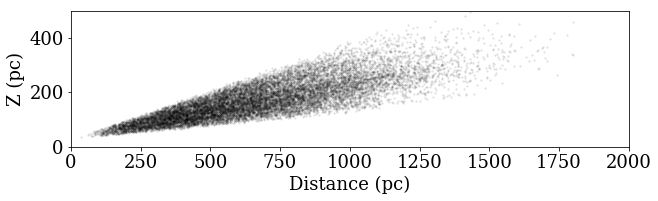

In [53]:
plt.figure(figsize=(10,2.5))
plt.scatter(dist, XYZ.z.value, alpha=0.12, c='k', lw=0, s=5)
plt.xlabel('Distance (pc)')
plt.ylabel('Z (pc)')
plt.xlim(0,2000)
plt.ylim(0,500)

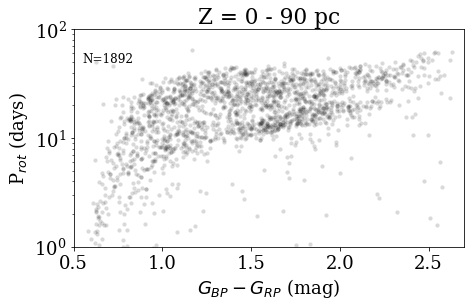

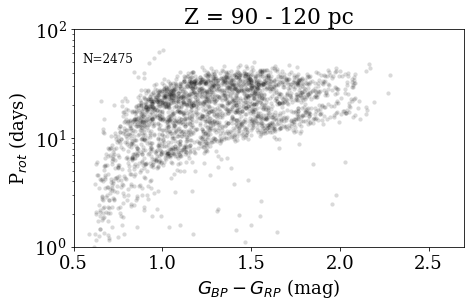

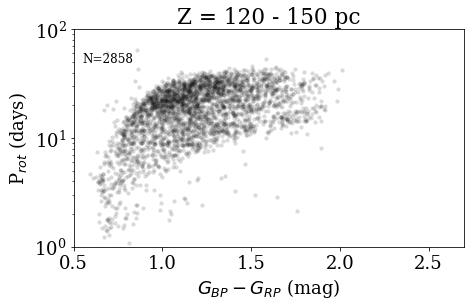

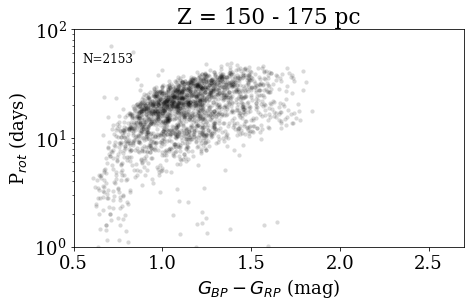

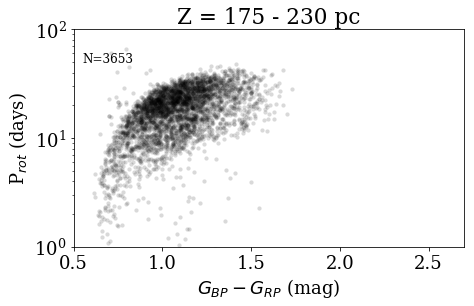

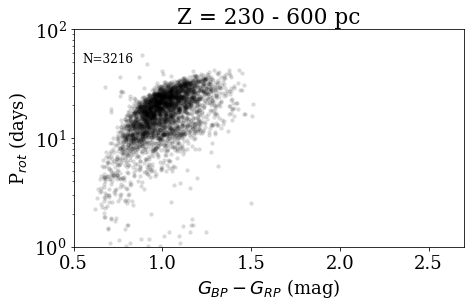

In [54]:
Zbins = np.array([0, 90, 120, 150, 175, 230, 600])

for k in range(len(Zbins)-1):
    dd = np.where((XYZ.z.value  >= Zbins[k]) & (XYZ.z.value  < Zbins[k+1]) )

    
    plt.figure(figsize=(7,4))
    plt.scatter(df[u'bp_rp'].values[ok][msok][dd], df[u'Prot'].values[ok][msok][dd], 
                s=18, alpha=0.15, c='k', lw=0, rasterized=False)
    
    plt.text(0.55,50, 'N='+str(np.size(dd)), fontsize=12)
    plt.yscale('log')
    plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
    plt.ylabel('P$_{rot}$ (days)');
    plt.xlim(0.5,2.7)
    plt.ylim(1,100)
    plt.title('Z = '+str(Zbins[k]) + ' - ' + str(Zbins[k+1]) + ' pc')
    plt.show()

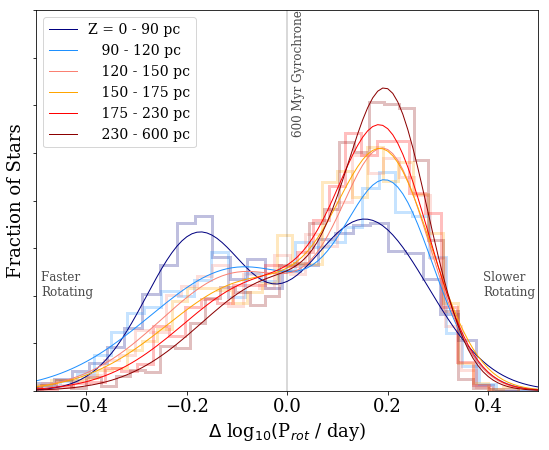

In [55]:
NBINS = 75
clr = ['DarkRed', 'red', 'orange', 'salmon', 'DodgerBlue', 'Navy']

fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
p2 = [3, -0.2, 0.01, 3, 0.2, 0.01]
ltmp = 'Z = '
for k in range(len(Zbins)-1):
    # for a restricted range of color, subtract off 600Myr gyrochrone
    dd = np.where((XYZ.z.value  >= Zbins[k]) & (XYZ.z.value  < Zbins[k+1]) &
                  (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))
     
    B_V_iso = np.arange(0.55,1.8,0.01)
    P_iso = MM09e2(B_V_iso, 600)
    plt.plot(B_V_iso, P_iso, c='r')

    rs = np.argsort(P_iso)
    red_P = np.interp(BV_ms[msok][dd], B_V_iso[rs], P_iso[rs])

    yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][dd]) - np.log10(red_P),
                        histtype='step', bins=NBINS, lw=3, alpha=0.25, color=clr[::-1][k], normed=True)
    
    bcent = (xx[:-1] + xx[1:])/2.
    
    popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
    perr2 = np.sqrt(np.diag(pcov2))

    dprot = np.arange(-1,1,0.01)
    plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c=clr[::-1][k], 
             label=ltmp + str(Zbins[k]) + ' - ' + str(Zbins[k+1]) + ' pc')
    ltmp = '   '

plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,4)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')
# add some annotations
plt.text(-0.49,1,'Faster \nRotating', fontsize=12, alpha=0.7)
plt.text(0.39,1,'Slower \nRotating', fontsize=12, alpha=0.7)
plt.plot([0,0], [0,4], alpha=0.2, c='k')
plt.text(0.01, 3.9, '600 Myr Gyrochrone', fontsize=12, alpha=0.7,rotation=90)

plt.savefig('../figures/delta_per_2gauss_Z'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

2327
2062
2267


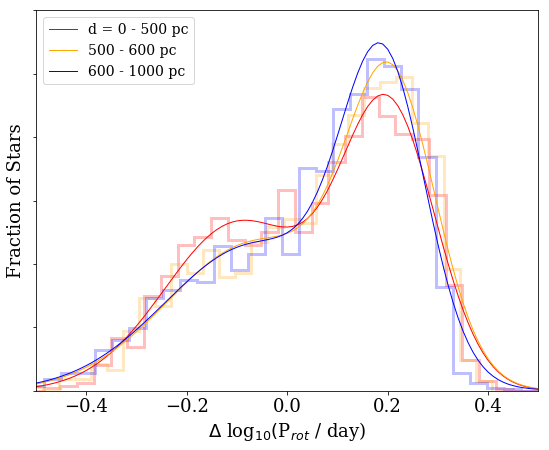

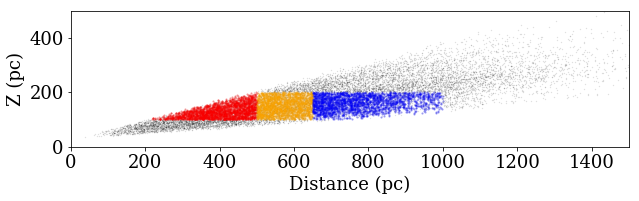

In [56]:
# now a 2d cut... in distance AND height, to compare the same height, but diff distances... 
# don't want to go down this rabbit hole TOO much yet. Need K2 sample

NBINS = 75

Z1 = np.where((XYZ.z.value  >= 100) & (XYZ.z.value  < 200) &
              (dist >= 0) & (dist < 500) &
              (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))
Z2 = np.where((XYZ.z.value  >= 100) & (XYZ.z.value  < 200) &
              (dist >= 500) & (dist < 650) &
              (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))
Z3 = np.where((XYZ.z.value  >= 100) & (XYZ.z.value  < 200) &
              (dist >= 650) & (dist < 1000) &
              (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))

print(len(Z1[0]))
print(len(Z2[0]))
print(len(Z3[0]))


fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
p2 = [3, -0.2, 0.01, 3, 0.2, 0.01]
ltmp = 'd = '

B_V_iso = np.arange(0.55,1.8,0.01)
P_iso = MM09e2(B_V_iso, 600)
plt.plot(B_V_iso, P_iso, c='r')
rs = np.argsort(P_iso)

red_P = np.interp(BV_ms[msok][Z1], B_V_iso[rs], P_iso[rs])
yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][Z1]) - np.log10(red_P),
                    histtype='step', bins=NBINS, lw=3, alpha=0.25, normed=True, color='red')
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))
dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c='red', 
         label='d = 0 - 500 pc')


red_P = np.interp(BV_ms[msok][Z2], B_V_iso[rs], P_iso[rs])
yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][Z2]) - np.log10(red_P),
                    histtype='step', bins=NBINS, lw=3, alpha=0.25, normed=True, color='orange')
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))
dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c='orange', 
         label='500 - 600 pc')


red_P = np.interp(BV_ms[msok][Z3], B_V_iso[rs], P_iso[rs])
yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][Z3]) - np.log10(red_P),
                    histtype='step', bins=NBINS, lw=3, alpha=0.25, normed=True, color='blue')
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))
dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c='blue', 
         label='600 - 1000 pc')


# plt.title('Z = 90 - 200 pc')

plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,3)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')
plt.savefig('../figures/delta_per_subZ2'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
plt.show()


plt.figure(figsize=(10,2.5))
plt.scatter(dist, XYZ.z.value, alpha=0.12, lw=0, s=2, c='k')
plt.scatter(dist[Z1], XYZ.z.value[Z1], alpha=0.3, lw=0, s=5, c='red')
plt.scatter(dist[Z2], XYZ.z.value[Z2], alpha=0.3,  lw=0, s=5, c='orange')
plt.scatter(dist[Z3], XYZ.z.value[Z3], alpha=0.3,  lw=0, s=5, c='blue')


plt.xlabel('Distance (pc)')
plt.ylabel('Z (pc)')
plt.xlim(0,1500)
plt.ylim(0,500)

plt.savefig('../figures/dist_Z2'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
plt.show()

915
924


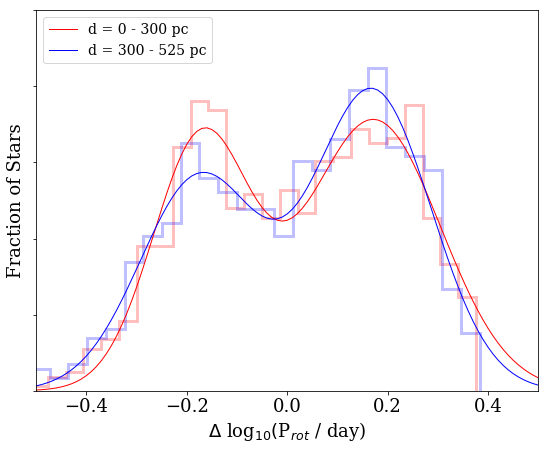

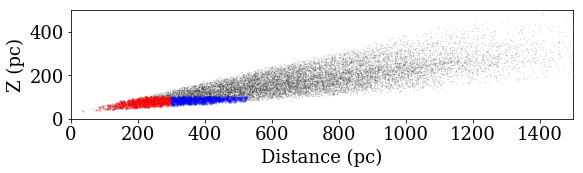

In [57]:
# now a 2d cut... in distance AND height, to compare the same height, but diff distances... 
# don't want to go down this rabbit hole TOO much yet. Need K2 sample

NBINS = 65

Z1 = np.where((XYZ.z.value  >= 0) & (XYZ.z.value  < 100) &
              (dist >= 0) & (dist < 300) &
              (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))
Z2 = np.where((XYZ.z.value  >= 0) & (XYZ.z.value  < 100) &
              (dist >= 300) & (dist < 525) &
              (BV_ms[msok] >= 0.8) &(BV_ms[msok] <= 1.45))

print(len(Z1[0]))
print(len(Z2[0]))



fig=plt.figure(figsize=(9,7))
ax = plt.subplot(111)
p2 = [3, -0.2, 0.01, 3, 0.2, 0.01]
ltmp = 'd = '

B_V_iso = np.arange(0.55,1.8,0.01)
P_iso = MM09e2(B_V_iso, 600)
plt.plot(B_V_iso, P_iso, c='r')
rs = np.argsort(P_iso)

red_P = np.interp(BV_ms[msok][Z1], B_V_iso[rs], P_iso[rs])
yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][Z1]) - np.log10(red_P),
                    histtype='step', bins=NBINS, lw=3, alpha=0.25, normed=True, color='red')
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))
dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c='red', 
         label='d = 0 - 300 pc')

red_P = np.interp(BV_ms[msok][Z2], B_V_iso[rs], P_iso[rs])
yy,xx, _ = plt.hist(np.log10(df[u'Prot'].values[ok][msok][Z2]) - np.log10(red_P),
                    histtype='step', bins=NBINS, lw=3, alpha=0.25, normed=True, color='blue')
bcent = (xx[:-1] + xx[1:])/2.
popt2, pcov2 = curve_fit(_gaus2, bcent, yy, p0=p2)
perr2 = np.sqrt(np.diag(pcov2))
dprot = np.arange(-1,1,0.01)
plt.plot(dprot, _gaus2(dprot, *popt2), lw=1, alpha=1, c='blue', 
         label='d = 300 - 525 pc')

plt.legend(fontsize=14, loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,2.5)
plt.xlabel(r'$\Delta$ log$_{10} ($P$_{rot}$ / day)')
plt.ylabel('Fraction of Stars')
ax.set_yticklabels('')
plt.savefig('../figures/delta_per_subZ'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)
plt.show()


plt.figure(figsize=(9,2))
plt.scatter(dist, XYZ.z.value, alpha=0.12, lw=0, s=2, c='k')
plt.scatter(dist[Z1], XYZ.z.value[Z1], alpha=0.3, lw=0, s=5, c='red')
plt.scatter(dist[Z2], XYZ.z.value[Z2], alpha=0.3,  lw=0, s=5, c='blue')

plt.xlabel('Distance (pc)')
plt.ylabel('Z (pc)')
plt.xlim(0,1500)
plt.ylim(0,500)

plt.savefig('../figures/dist_Z'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

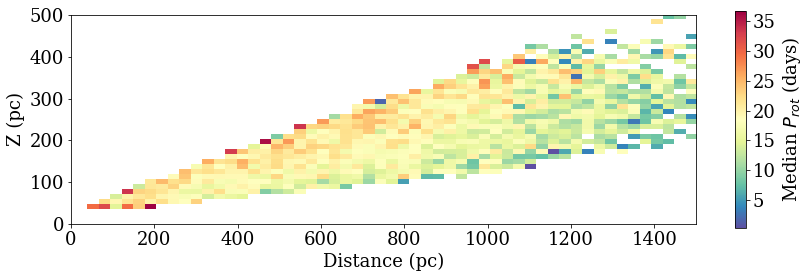

In [58]:
from scipy.stats import binned_statistic_2d

plt.figure(figsize=(14,4))

# plt.scatter(dist, XYZ.z.value, alpha=0.5, lw=0, s=5, c=(df[u'Prot'].values[ok][msok]))

ret = binned_statistic_2d(dist, XYZ.z.value, df[u'Prot'].values[ok][msok], 
                          statistic='median', bins=[75,50])
plt.imshow(ret.statistic.T, interpolation='nearest', origin='lower', cmap=plt.cm.Spectral_r, 
           extent=(ret.x_edge[0], ret.x_edge[-1], ret.y_edge[0], ret.y_edge[-1]))

cb = plt.colorbar()
cb.set_label('Median $P_{rot}$ (days)')
plt.xlabel('Distance (pc)')
plt.ylabel('Z (pc)')
plt.xlim(0,1500)
plt.ylim(0,500)
plt.savefig('../figures/dist_Z_median'+ftype, dpi=300, bbox_inches='tight', pad_inches=0.25)

## spindown vs mass
expand on the Figure shown in the paper briefly...

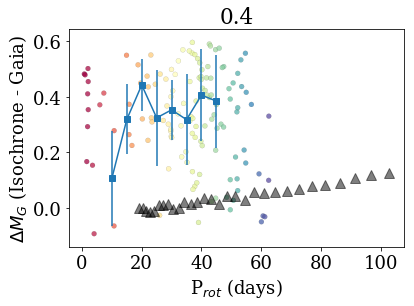

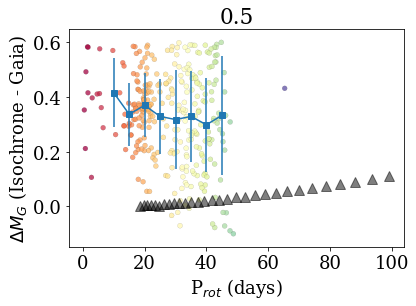

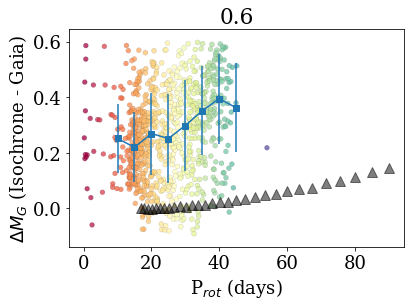

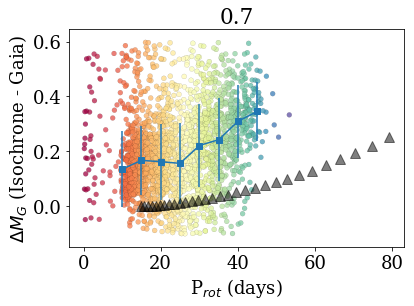

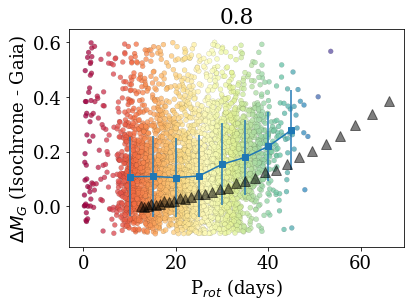

/Users/james/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/james/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


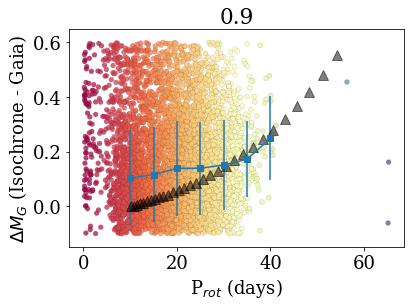

In [59]:
arng = np.where((mist['log10_isochrone_age_yr'] > 8.5) & (mist['log10_isochrone_age_yr'] <= 10) )
Mist_ages_m = np.unique(mist['log10_isochrone_age_yr'].values[arng])

m2 = np.where((mist['log10_isochrone_age_yr'] == Mist_ages[80]) & (mist['Gaia_G_DR2Rev'] > 2)) # 1e9 yrs


dm = 0.05 # +/- mass range
mm = np.array([.4, .5, .6, .7, .8, .9]) # M_sun
for k in range(len(mm)):
    plt.figure()
    
    M_point = mm[k]

    # plausible color range for stars over this mass range
    crng_m = np.interp([M_point+dm, M_point-dm], mist['star_mass'].values[mist_ms1][::-1], 
                       mist['Gaia_BP_DR2Rev'].values[mist_ms1][::-1] - mist['Gaia_RP_DR2Rev'].values[mist_ms1][::-1])
#     print(crng_m)


    rb_ok = np.where((df[u'bp_rp'].values[ok] > crng_m[0]) & (df[u'bp_rp'].values[ok] < crng_m[1]) & 
                      (delta_mag_mist > -0.1) & (delta_mag_mist < 0.6))[0]

    plt.scatter(df[u'Prot'].values[ok][rb_ok], delta_mag_mist[rb_ok], c=(df[u'Prot'].values[ok][rb_ok]),
                s=25, alpha=0.75, cmap=cm, edgecolors='k', lw=0.1, rasterized=False)

    dy = 5
    yy = np.arange(10,50,dy)
    xx = np.zeros_like(yy, dtype='float')
    xxe = np.zeros_like(yy, dtype='float')
    for k in range(len(yy)):
        xok = np.where((df[u'Prot'].values[ok][rb_ok] >= yy[k]-dy/2.) & (df[u'Prot'].values[ok][rb_ok] < (yy[k]+dy/2.)))
        xx[k] = np.nanmedian(delta_mag_mist[rb_ok][xok])
        xxe[k] = np.nanstd(delta_mag_mist[rb_ok][xok]) 

    plt.errorbar(yy,xx, yerr=xxe, marker='s')
    plt.title(str(M_point))
    
    BV07 = np.interp(M_point, iso2['Mass'].values[iok][::-1], 
                     iso2['Bmag'].values[iok][::-1] - iso2['Vmag'].values[iok][::-1])

    zp = 0
    for j in range(len(Mist_ages_m)):
        aa = Mist_ages_m[j]
        aok = np.where((mist['log10_isochrone_age_yr'] == aa) & (mist['phase']==0))
        new_G = np.interp(M_point, mist['star_mass'].values[aok], 
                          mist['Gaia_G_DR2Rev'].values[aok])
        if j==0:
            zp = new_G
        plt.plot(MM09e2(BV07, (10.**aa)/1e6), zp - new_G, marker='^', c='k', alpha=0.5, zorder=2, markersize=10)

    plt.ylabel(r'$\Delta M_G$ (Isochrone - Gaia)')
    plt.xlabel('P$_{rot}$ (days)')
    plt.show()
